Visualization of COVID-19 Healthcare Misinformation Dataset (CoAID)

This project 

Datasource: https://github.com/cuilimeng/CoAID/tree/master

Objective

This project aimed to identify the themes and the most common words used for COVID-19 misinformation.



In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

In [164]:
# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

# Load data (05-01-2020)
fake_claims = pd.read_csv('ClaimFakeCOVID-19.csv')
real_claims = pd.read_csv('ClaimRealCOVID-19.csv')

fake_claims['label'] = 'Fake'
real_claims['label'] = 'Real'

df_claims = pd.concat([fake_claims, real_claims], ignore_index=True)

In [166]:
# Feature engineering
df_claims['claim_length'] = df_claims['title'].str.len()
df_claims['claim_word_count'] = df_claims['title'].str.split().str.len()
df_claims['avg_word_length'] = df_claims['title'].apply(
    lambda x: np.mean([len(word) for word in str(x).split()]) if pd.notna(x) and len(str(x).split()) > 0 else 0
)

In [167]:
# VADER Sentiment
vader_analyzer = SentimentIntensityAnalyzer()

def get_vader_scores(text):
    """Get VADER sentiment scores."""
    if pd.notna(text):
        scores = vader_analyzer.polarity_scores(str(text))
        return pd.Series({
            'vader_positive': scores['pos'],
            'vader_negative': scores['neg'],
            'vader_neutral': scores['neu'],
            'vader_compound': scores['compound']
        })
    else:
        return pd.Series({
            'vader_positive': 0,
            'vader_negative': 0,
            'vader_neutral': 1,
            'vader_compound': 0
        })

# Apply VADER to all titles
vader_scores = df_claims['title'].apply(get_vader_scores)
df_claims = pd.concat([df_claims, vader_scores], axis=1)

In [168]:
# Sentiment
df_claims['sentiment_polarity'] = df_claims['title'].apply(
    lambda x: TextBlob(str(x)).sentiment.polarity if pd.notna(x) else 0
)
df_claims['sentiment_subjectivity'] = df_claims['title'].apply(
    lambda x: TextBlob(str(x)).sentiment.subjectivity if pd.notna(x) else 0
)



In [169]:
# Certainty language

certainty_words = [
    'definitely', 'absolutely', 'certainly', 'always', 'never', 'proven', 'confirmed', 'fact', 'truth', '100%',
    'completely', 'undeniable', 'undoubtedly', 'obviously', 'clearly', 'guaranteed', 'irrefutable', 'incontrovertible',
    'beyond doubt', 'evident', 'infallible', 'verified', 'validated', 'scientifically proven', 'official', 'decisive'
]

df_claims['certainty_score'] = df_claims['title'].str.lower().apply(
    lambda x: sum(word in str(x) for word in certainty_words) if pd.notna(x) else 0
)

In [170]:
# Punctuation
df_claims['exclamation_count'] = df_claims['title'].str.count('!')
df_claims['question_count'] = df_claims['title'].str.count('\?')
df_claims['has_question'] = (
    (df_claims['exclamation_count'] > 0) | (df_claims['question_count'] > 0)
).astype(int)

In [171]:
# Fact-checker source
from urllib.parse import urlparse
df_claims['fact_checker'] = df_claims['fact_check_url'].apply(
    lambda x: urlparse(str(x)).netloc.replace('www.', '') if pd.notna(x) else 'Unknown'
)

In [172]:
print(f"Dataset loaded: {len(df_claims)} claims ({len(fake_claims)} fake, {len(real_claims)} real)")

Dataset loaded: 193 claims (27 fake, 166 real)


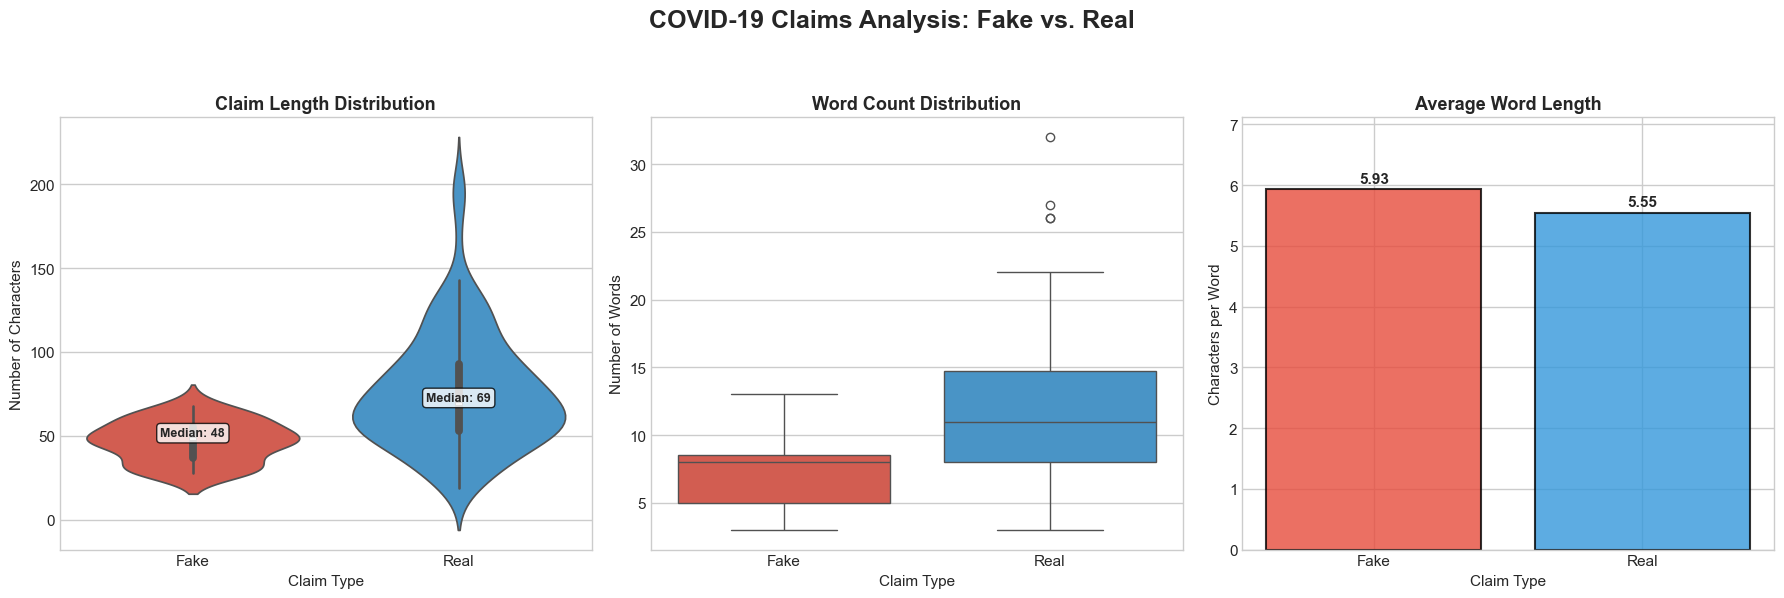

✓ Saved: viz1_overview_dashboard.png


In [173]:
# =============================================
# VIZ 1: OVERVIEW DASHBOARD
# =============================================

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('COVID-19 Claims Analysis: Fake vs. Real', 
             fontsize=18, fontweight='bold', y=0.995)

# Color palette
colors = {'Fake': '#E74C3C', 'Real': '#3498DB'}

# 1. Claim Length Distribution
sns.violinplot(data=df_claims, x='label', y='claim_length', ax=axes[0],
               palette=colors, inner='box')
axes[0].set_title('Claim Length Distribution', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Claim Type', fontsize=11)
axes[0].set_ylabel('Number of Characters', fontsize=11)

# Add median values
for i, label in enumerate(['Fake', 'Real']):
    median = df_claims[df_claims['label']==label]['claim_length'].median()
    axes[0].text(i, median, f'Median: {median:.0f}', 
                 ha='center', va='bottom', fontsize=9, fontweight='bold',
                 bbox=dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.8))

# 2. Word Count Distribution
sns.boxplot(data=df_claims, x='label', y='claim_word_count', ax=axes[1],
            palette=colors)
axes[1].set_title('Word Count Distribution', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Claim Type', fontsize=11)
axes[1].set_ylabel('Number of Words', fontsize=11)

# 3. Average Word Length
word_length_means = df_claims.groupby('label')['avg_word_length'].mean()
bars = axes[2].bar(word_length_means.index, word_length_means.values, 
                   color=[colors[x] for x in word_length_means.index],
                   edgecolor='black', linewidth=1.5, alpha=0.8)
axes[2].set_title('Average Word Length', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Claim Type', fontsize=11)
axes[2].set_ylabel('Characters per Word', fontsize=11)
axes[2].set_ylim(0, word_length_means.max() * 1.2)

# Add value labels
for bar, val in zip(bars, word_length_means.values):
    axes[2].text(bar.get_x() + bar.get_width()/2, val + 0.05, 
                 f'{val:.2f}', ha='center', va='bottom', 
                 fontsize=11, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('viz1_overview_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: viz1_overview_dashboard.png")


In [174]:
# =============================================
# VIZ 2: INTERACTIVE SENTIMENT ANALYSIS
# =============================================

# Sample for better performance
sample_size = min(2000, len(df_claims))
df_sample = df_claims.sample(n=sample_size, random_state=42)

fig = px.scatter(df_sample,
                 x='sentiment_polarity',
                 y='sentiment_subjectivity',
                 color='label',
                 size='claim_word_count',
                 hover_data={
                     'title': True,
                     'claim_length': True,
                     'claim_word_count': True,
                     'certainty_score': True,
                     'sentiment_polarity': ':.3f',
                     'sentiment_subjectivity': ':.3f'
                 },
                 title='<b>Sentiment Analysis: COVID-19 Claims</b>',
                 labels={
                     'sentiment_polarity': 'Sentiment Polarity',
                     'sentiment_subjectivity': 'Sentiment Subjectivity',
                     'label': 'Claim Type',
                     'claim_word_count': 'Word Count'
                 },
                 color_discrete_map={'Fake': '#E74C3C', 'Real': '#3498DB'},
                 opacity=0.7)

# Add reference lines
fig.add_hline(y=0.5, line_dash="dot", line_color="gray", 
              annotation_text="Subjectivity = 0.5", annotation_position="right")
fig.add_vline(x=0, line_dash="dot", line_color="gray",
              annotation_text="Neutral", annotation_position="top")

# Add quadrant labels
fig.add_annotation(x=-0.7, y=0.9, text="<b>Negative & Subjective</b>",
                  showarrow=False, font=dict(size=11, color="gray"), opacity=0.6)
fig.add_annotation(x=0.7, y=0.9, text="<b>Positive & Subjective</b>",
                  showarrow=False, font=dict(size=11, color="gray"), opacity=0.6)
fig.add_annotation(x=-0.7, y=0.1, text="<b>Negative & Objective</b>",
                  showarrow=False, font=dict(size=11, color="gray"), opacity=0.6)
fig.add_annotation(x=0.7, y=0.1, text="<b>Positive & Objective</b>",
                  showarrow=False, font=dict(size=11, color="gray"), opacity=0.6)

fig.update_layout(
    template='plotly_white',
    font=dict(size=12),
    title_font_size=18,
    width=1100,
    height=700,
    legend=dict(
        title_font_size=13,
        font_size=11,
        orientation="v",
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99,
        bgcolor="rgba(255,255,255,0.8)"
    ),
    xaxis=dict(title_font_size=13, gridcolor='lightgray'),
    yaxis=dict(title_font_size=13, gridcolor='lightgray')
)

fig.show()
fig.write_html('viz2_sentiment_scatter.html')
fig.write_image("viz2_sentiment_scatter.png", scale=2)
print("✓ Saved: viz2_sentiment_scatter.html")

✓ Saved: viz2_sentiment_scatter.html


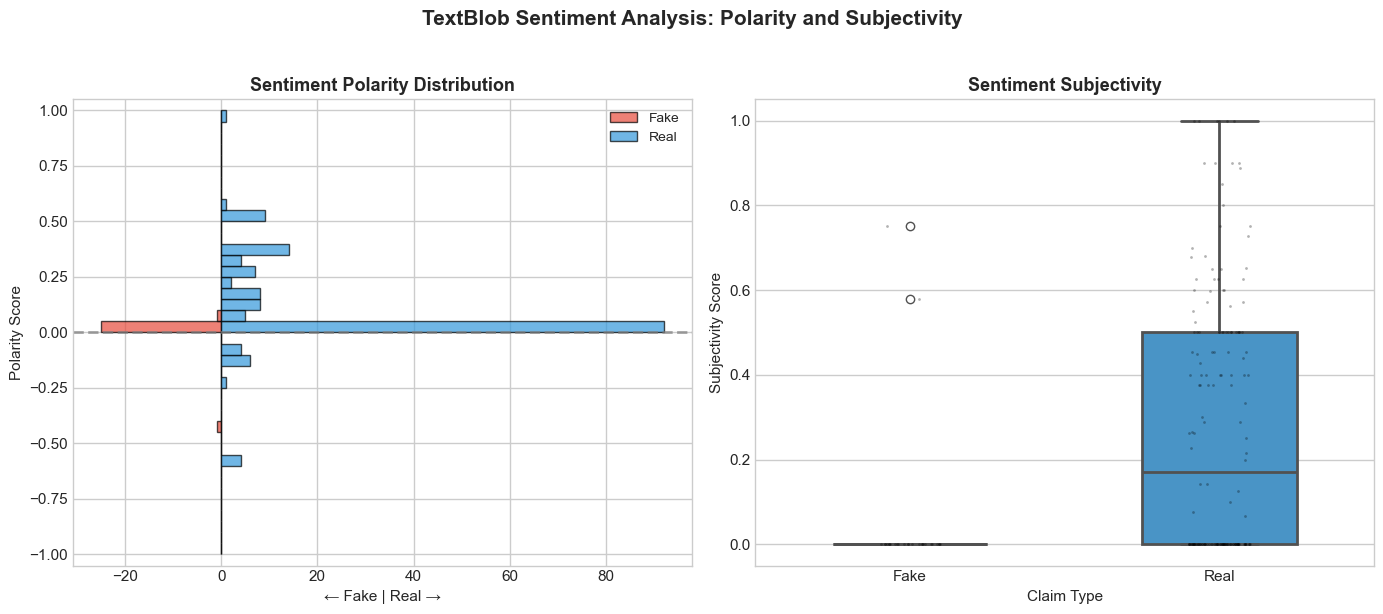

In [175]:
# Create figure with 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Define colors
colors = {'Fake': '#E74C3C', 'Real': '#3498DB'}

# =============================================
# LEFT PLOT: Sentiment Polarity (Back-to-Back Histogram)
# =============================================
fake_counts, bins = np.histogram(df_claims[df_claims['label']=='Fake']['sentiment_polarity'], 
                                  bins=40, range=(-1, 1))
real_counts, _ = np.histogram(df_claims[df_claims['label']=='Real']['sentiment_polarity'], 
                              bins=bins)

axes[0].barh(bins[:-1], -fake_counts, height=np.diff(bins), 
             align='edge', alpha=0.7, color=colors['Fake'], label='Fake', edgecolor='black')
axes[0].barh(bins[:-1], real_counts, height=np.diff(bins), 
             align='edge', alpha=0.7, color=colors['Real'], label='Real', edgecolor='black')
axes[0].set_title('Sentiment Polarity Distribution', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Polarity Score', fontsize=11)
axes[0].set_xlabel('← Fake | Real →', fontsize=11)
axes[0].axhline(y=0, color='gray', linestyle='--', linewidth=2, alpha=0.7)
axes[0].legend(fontsize=10)
axes[0].set_ylim(-1.05, 1.05)

# =============================================
# RIGHT PLOT: Sentiment Subjectivity (Box + Strip)
# =============================================
sns.boxplot(data=df_claims, x='label', y='sentiment_subjectivity', ax=axes[1],
            palette=colors, width=0.5, linewidth=2)
sns.stripplot(data=df_claims, x='label', y='sentiment_subjectivity', ax=axes[1],
              color='black', alpha=0.3, size=2, jitter=True)
axes[1].set_title('Sentiment Subjectivity', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Claim Type', fontsize=11)
axes[1].set_ylabel('Subjectivity Score', fontsize=11)
axes[1].set_ylim(-0.05, 1.05)

# Overall title
fig.suptitle('TextBlob Sentiment Analysis: Polarity and Subjectivity', 
             fontsize=15, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig('viz_textblob_sentiment.png', dpi=300, bbox_inches='tight')
plt.show()


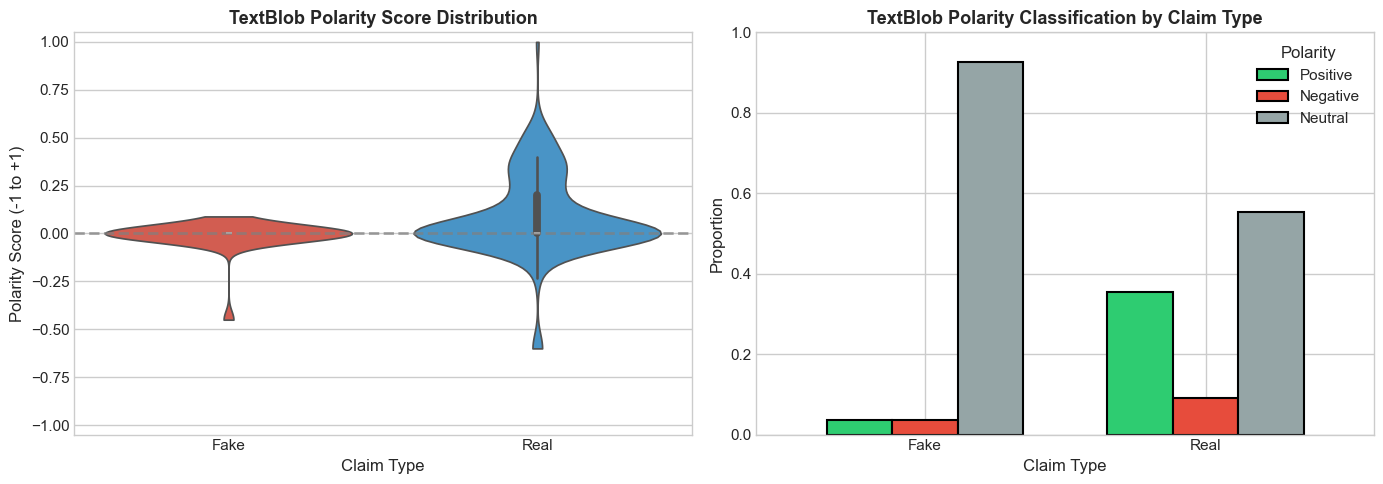

In [176]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Polarity score distribution (violin plot)
sns.violinplot(data=df_claims, x='label', y='sentiment_polarity', 
               palette=['#E74C3C', '#3498DB'], ax=axes[0], cut=0)
axes[0].set_title('TextBlob Polarity Score Distribution', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Claim Type')
axes[0].set_ylabel('Polarity Score (-1 to +1)')
axes[0].axhline(y=0, color='gray', linestyle='--', linewidth=2, alpha=0.7)
axes[0].set_ylim(-1.05, 1.05)

# Categorize polarity
def categorize_polarity(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

df_claims['polarity_category'] = df_claims['sentiment_polarity'].apply(categorize_polarity)

# Calculate proportions
polarity_counts = df_claims.groupby(['label', 'polarity_category']).size().unstack(fill_value=0)
polarity_proportions = polarity_counts.div(polarity_counts.sum(axis=1), axis=0)

# Consistent color order: Positive (green), Negative (red), Neutral (gray)
column_order = ['Positive', 'Negative', 'Neutral']
colors = ['#2ECC71', '#E74C3C', '#95A5A6']
polarity_proportions = polarity_proportions[[col for col in column_order if col in polarity_proportions.columns]]

# Right: grouped bar chart
polarity_proportions.plot(kind='bar', ax=axes[1], 
                          color=colors,
                          edgecolor='black', linewidth=1.5, width=0.7)
axes[1].set_title('TextBlob Polarity Classification by Claim Type', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Claim Type')
axes[1].set_ylabel('Proportion')
axes[1].legend(title='Polarity', labels=[col for col in column_order if col in polarity_proportions.columns])
axes[1].tick_params(axis='x', rotation=0)
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.savefig('viz_textblob_polarity.png', dpi=300, bbox_inches='tight')
plt.show()


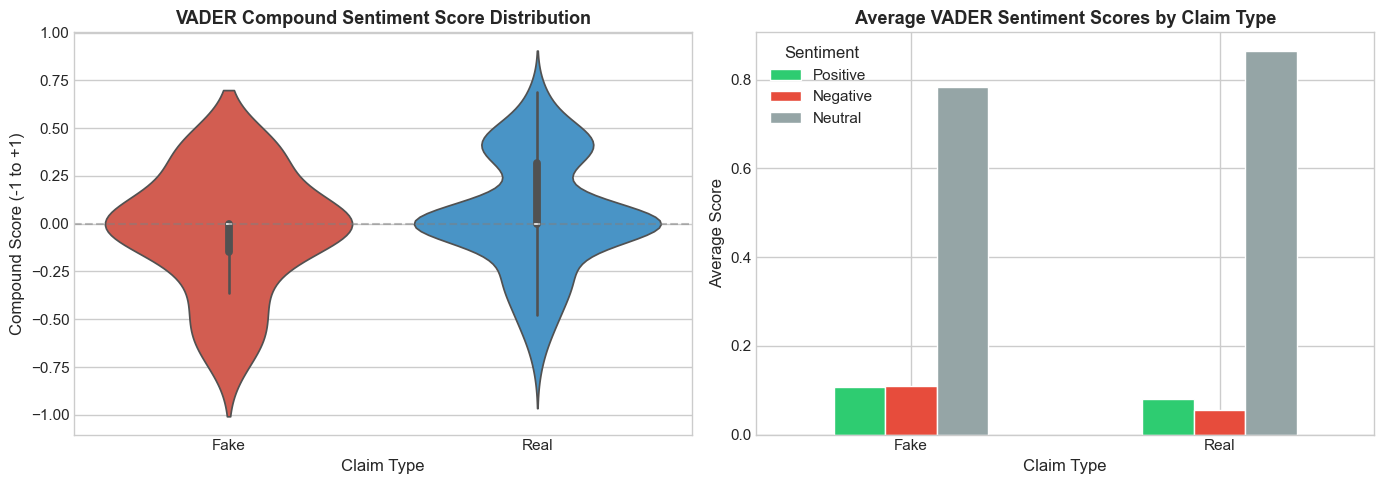

In [177]:
# Compare VADER compound scores between Fake and Real
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Compound score distribution
sns.violinplot(data=df_claims, x='label', y='vader_compound', palette=['#E74C3C', '#3498DB'], ax=axes[0])
axes[0].set_title('VADER Compound Sentiment Score Distribution', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Claim Type')
axes[0].set_ylabel('Compound Score (-1 to +1)')
axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)

# Positive vs Negative
sentiment_comparison = df_claims.groupby('label')[['vader_positive', 'vader_negative', 'vader_neutral']].mean()
sentiment_comparison.plot(kind='bar', ax=axes[1], color=['#2ECC71', '#E74C3C', '#95A5A6'])
axes[1].set_title('Average VADER Sentiment Scores by Claim Type', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Claim Type')
axes[1].set_ylabel('Average Score')
axes[1].legend(title='Sentiment', labels=['Positive', 'Negative', 'Neutral'])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('viz1_vader.png', dpi=300, bbox_inches='tight')
plt.show()

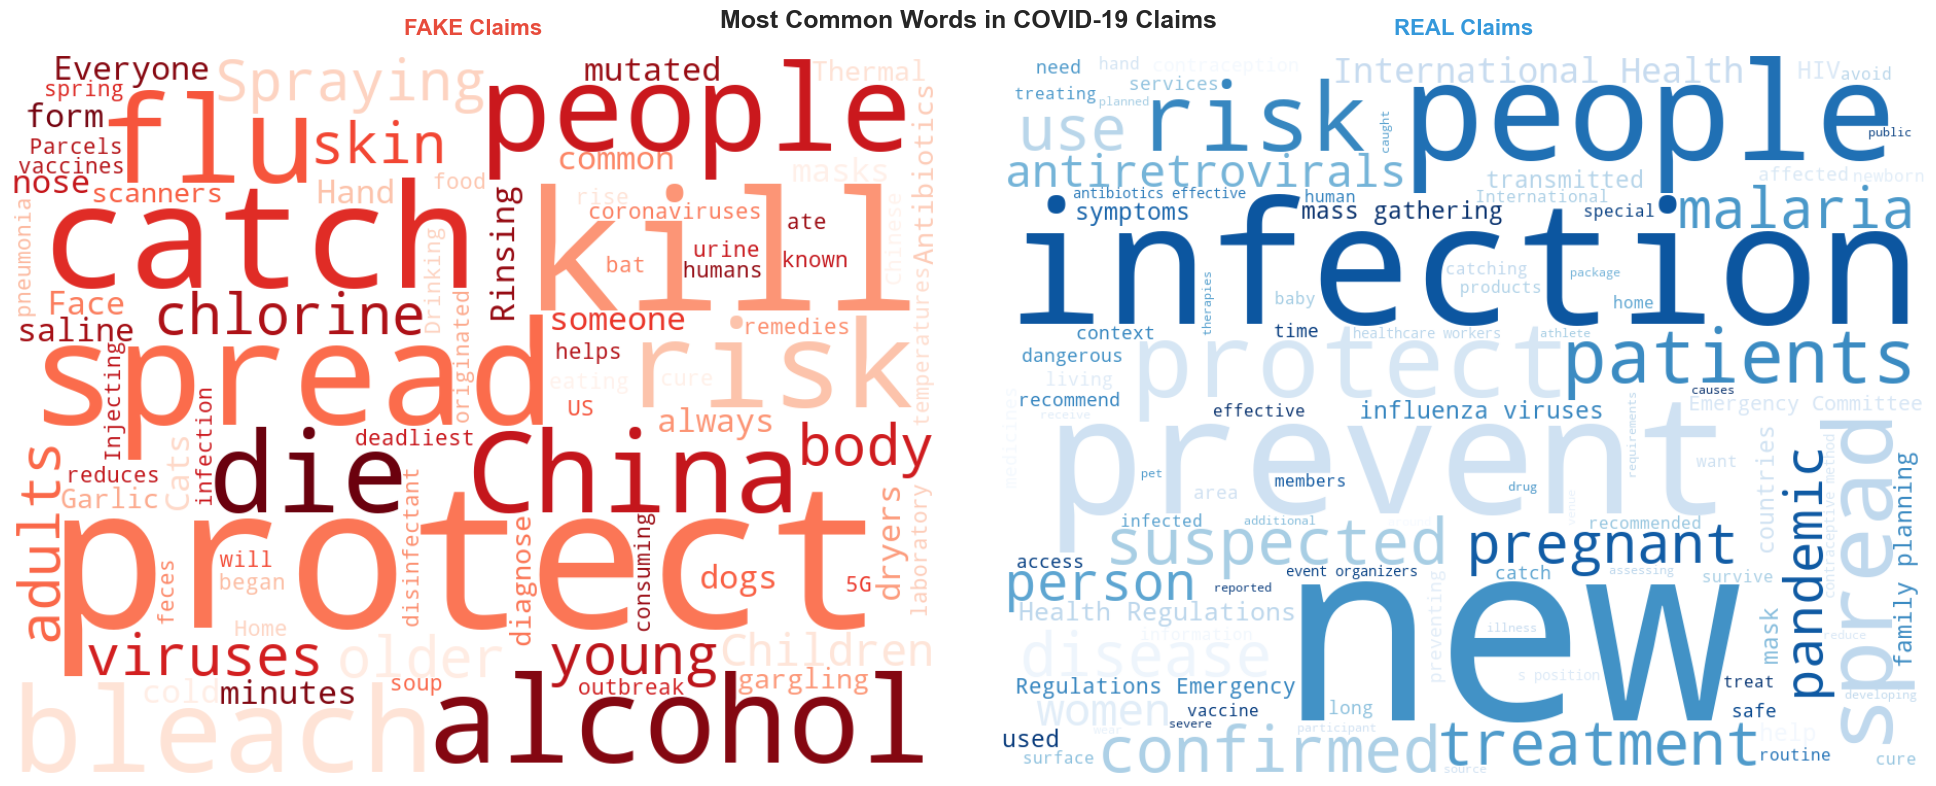

✓ Saved: viz3_wordclouds.png


In [180]:
# =============================================
# VIZ 3: WORD CLOUDS COMPARISON
# =============================================

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Most Common Words in COVID-19 Claims', 
             fontsize=18, fontweight='bold', y=0.98)

# Stopwords
stop_words = set(STOPWORDS)
stop_words.update(['covid', 'covid19', 'covid-19', 'coronavirus', 'virus', '2019', '19', '2019ncov',
    'cov', 'ncov', 'sars', 'sars-cov', 'sars-cov-2', 'corona', 'claim', 'says', 'said'])

# Function to normalize word variations
def normalize_text(text_series):
    """Replace plural/verb forms with base forms."""
    text = ' '.join(text_series.dropna().astype(str))
    text = text.replace('kills', 'kill').replace('Kills', 'kill')
    text = text.replace('protects', 'protect').replace('Protects', 'protect')
    return text

# Fake claims
fake_text = normalize_text(df_claims[df_claims['label']=='Fake']['title'])
wc_fake = WordCloud(width=900, height=700,
                    background_color='white',
                    stopwords=stop_words,
                    colormap='Reds',
                    max_words=100,
                    relative_scaling=0.5,
                    contour_color='#E74C3C',
                    contour_width=2).generate(fake_text)

axes[0].imshow(wc_fake, interpolation='bilinear')
axes[0].set_title('FAKE Claims', fontsize=16, fontweight='bold', 
                  color='#E74C3C', pad=15)
axes[0].axis('off')

# Real claims
real_text = normalize_text(df_claims[df_claims['label']=='Real']['title'])
wc_real = WordCloud(width=900, height=700,
                    background_color='white',
                    stopwords=stop_words,
                    colormap='Blues',
                    max_words=100,
                    relative_scaling=0.5,
                    contour_color='#3498DB',
                    contour_width=2).generate(real_text)

axes[1].imshow(wc_real, interpolation='bilinear')
axes[1].set_title('REAL Claims', fontsize=16, fontweight='bold',
                  color='#3498DB', pad=15)
axes[1].axis('off')

plt.tight_layout()
plt.savefig('viz3_wordclouds.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: viz3_wordclouds.png")

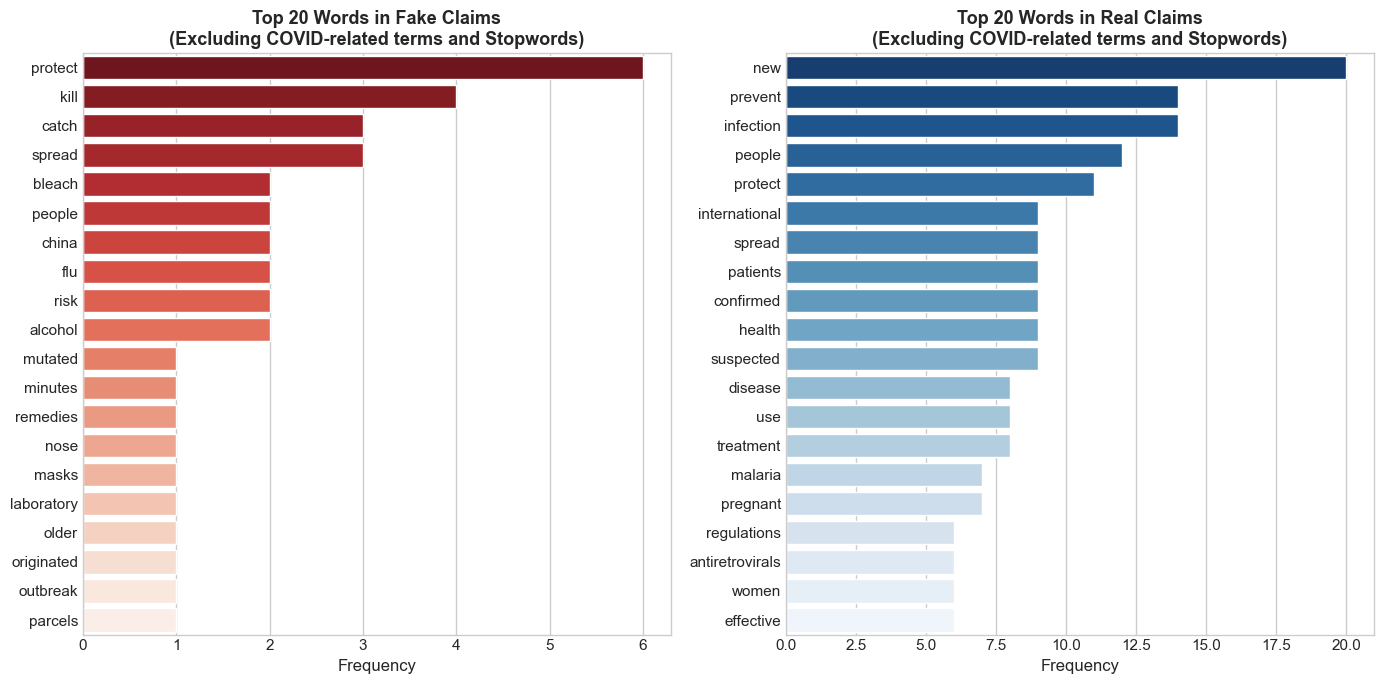

In [181]:
from wordcloud import STOPWORDS

# Define COVID-related words to exclude
covid_terms = {
    'covid', 'covid19', 'covid-19', 'coronavirus', 'virus', '2019', '19', '2019ncov',
    'cov', 'ncov', 'sars', 'sars-cov', 'sars-cov-2', 'corona', 'claim', 'says', 'said'
}

# Create unified stopwords (same as word cloud)
stop_words = set(STOPWORDS)
stop_words.update(covid_terms)

def get_top_unigrams(text_series):
    """Extract top unigrams (excluding COVID-related words)."""
    # Replace plural/verb forms with base forms
    text_series = text_series.str.replace(r'\bkills\b', 'kill', case=False, regex=True)
    text_series = text_series.str.replace(r'\bprotects\b', 'protect', case=False, regex=True)
    
    # Use the same stopwords as word cloud instead of 'english'
    vectorizer = CountVectorizer(stop_words=list(stop_words))
    X = vectorizer.fit_transform(text_series)
    word_counts = pd.DataFrame({
        'word': vectorizer.get_feature_names_out(),
        'count': X.toarray().sum(axis=0)
    })
    # Top 20 most frequent words
    return word_counts.sort_values('count', ascending=False).head(20)

# Get top words for each label
top_fake = get_top_unigrams(df_claims[df_claims['label'] == 'Fake']['title'])
top_real = get_top_unigrams(df_claims[df_claims['label'] == 'Real']['title'])

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharex=False, sharey=False)

sns.barplot(data=top_fake, y='word', x='count', palette='Reds_r', ax=axes[0])
axes[0].set_title("Top 20 Words in Fake Claims\n(Excluding COVID-related terms and Stopwords)", fontsize=13, fontweight='bold')
axes[0].set_xlabel("Frequency")
axes[0].set_ylabel("")

sns.barplot(data=top_real, y='word', x='count', palette='Blues_r', ax=axes[1])
axes[1].set_title("Top 20 Words in Real Claims\n(Excluding COVID-related terms and Stopwords)", fontsize=13, fontweight='bold')
axes[1].set_xlabel("Frequency")
axes[1].set_ylabel("")

plt.tight_layout()
plt.savefig('viz3_barplot.png', dpi=300, bbox_inches='tight')
plt.show()

=== BIGRAMS (2-word phrases) ===


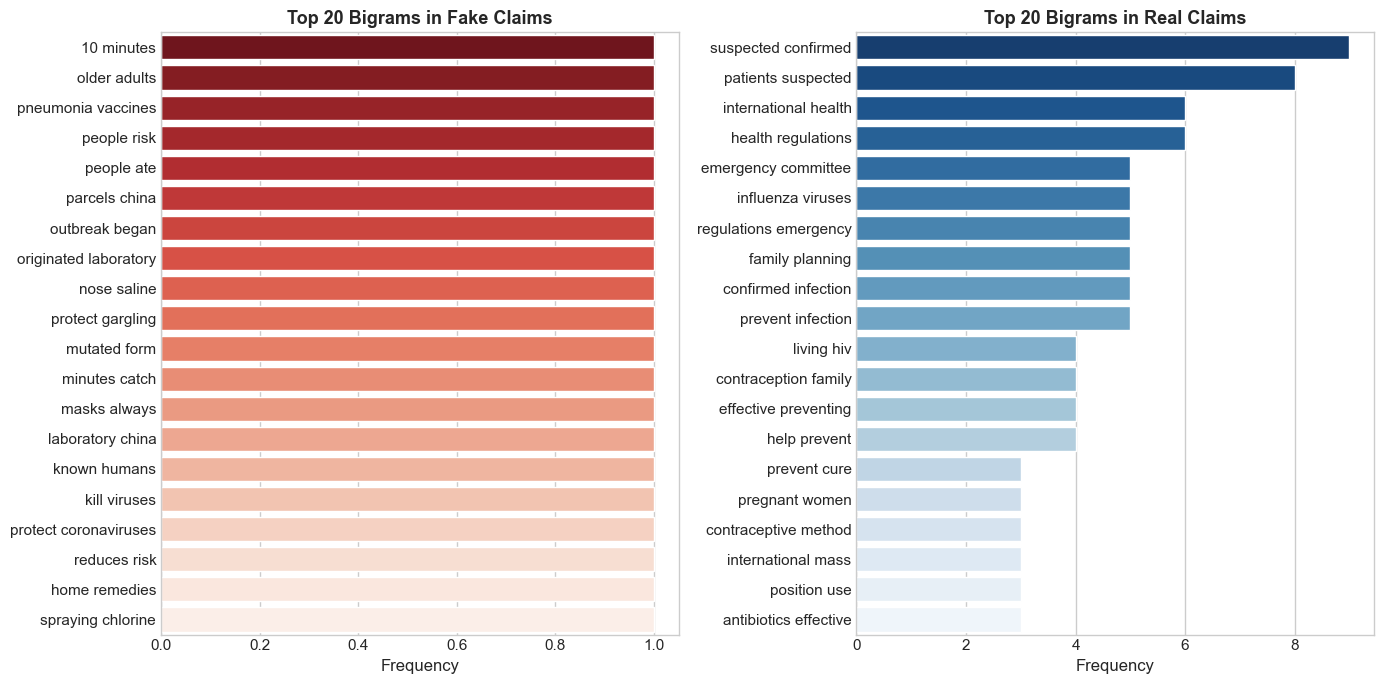

In [182]:
from wordcloud import STOPWORDS

# Define COVID-related words to exclude
covid_terms = {
    'covid', 'covid19', 'covid-19', 'coronavirus', 'virus', '2019', '19', '2019ncov',
    'cov', 'ncov', 'sars', 'sars-cov', 'sars-cov-2', 'corona', 'claim', 'says', 'said'
}

# Create unified stopwords (same as word cloud)
stop_words = set(STOPWORDS)
stop_words.update(covid_terms)

def get_top_ngrams(text_series, ngram_range=(1,1), top_n=20):
    """Extract top n-grams (excluding COVID-related words)."""
    # Replace plural/verb forms with base forms
    text_series = text_series.str.replace(r'\bkills\b', 'kill', case=False, regex=True)
    text_series = text_series.str.replace(r'\bprotects\b', 'protect', case=False, regex=True)
    
    # Use the same stopwords as word cloud
    vectorizer = CountVectorizer(stop_words=list(stop_words), ngram_range=ngram_range)
    X = vectorizer.fit_transform(text_series)
    word_counts = pd.DataFrame({
        'word': vectorizer.get_feature_names_out(),
        'count': X.toarray().sum(axis=0)
    })
    # Top N most frequent words/phrases
    return word_counts.sort_values('count', ascending=False).head(top_n)

# Example: Get bigrams
print("=== BIGRAMS (2-word phrases) ===")
top_fake_bigrams = get_top_ngrams(df_claims[df_claims['label'] == 'Fake']['title'], ngram_range=(2,2))
top_real_bigrams = get_top_ngrams(df_claims[df_claims['label'] == 'Real']['title'], ngram_range=(2,2))

# Create side-by-side plots for BIGRAMS
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

sns.barplot(data=top_fake_bigrams, y='word', x='count', palette='Reds_r', ax=axes[0])
axes[0].set_title("Top 20 Bigrams in Fake Claims", fontsize=13, fontweight='bold')
axes[0].set_xlabel("Frequency")
axes[0].set_ylabel("")

sns.barplot(data=top_real_bigrams, y='word', x='count', palette='Blues_r', ax=axes[1])
axes[1].set_title("Top 20 Bigrams in Real Claims", fontsize=13, fontweight='bold')
axes[1].set_xlabel("Frequency")
axes[1].set_ylabel("")

plt.tight_layout()
plt.savefig('viz3_barplot2.png', dpi=300, bbox_inches='tight')
plt.show()



=== TRIGRAMS (3-word phrases) ===


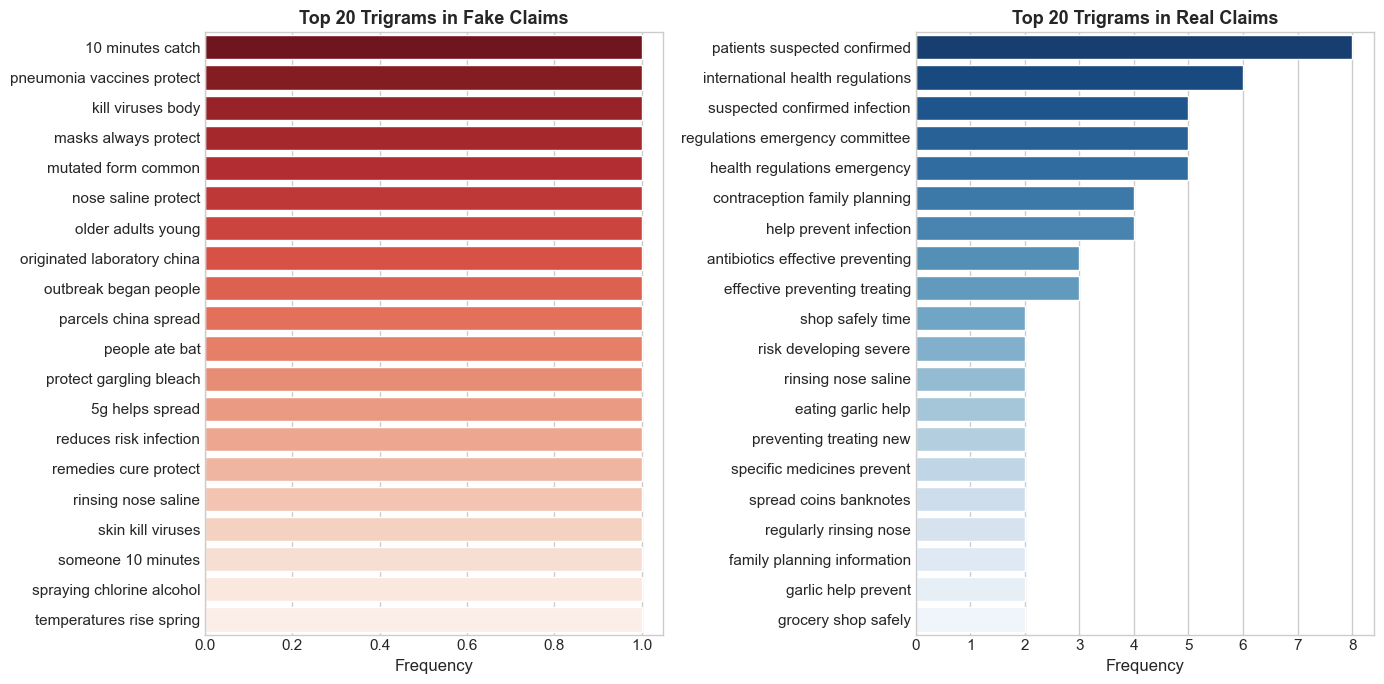

In [183]:
# Example: Get trigrams
print("\n=== TRIGRAMS (3-word phrases) ===")
top_fake_trigrams = get_top_ngrams(df_claims[df_claims['label'] == 'Fake']['title'], ngram_range=(3,3))
top_real_trigrams = get_top_ngrams(df_claims[df_claims['label'] == 'Real']['title'], ngram_range=(3,3))

# Create side-by-side plots for TRIGRAMS
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

sns.barplot(data=top_fake_trigrams, y='word', x='count', palette='Reds_r', ax=axes[0])
axes[0].set_title("Top 20 Trigrams in Fake Claims", fontsize=13, fontweight='bold')
axes[0].set_xlabel("Frequency")
axes[0].set_ylabel("")

sns.barplot(data=top_real_trigrams, y='word', x='count', palette='Blues_r', ax=axes[1])
axes[1].set_title("Top 20 Trigrams in Real Claims", fontsize=13, fontweight='bold')
axes[1].set_xlabel("Frequency")
axes[1].set_ylabel("")

plt.tight_layout()
plt.savefig('viz3_barplot3.png', dpi=300, bbox_inches='tight')
plt.show()

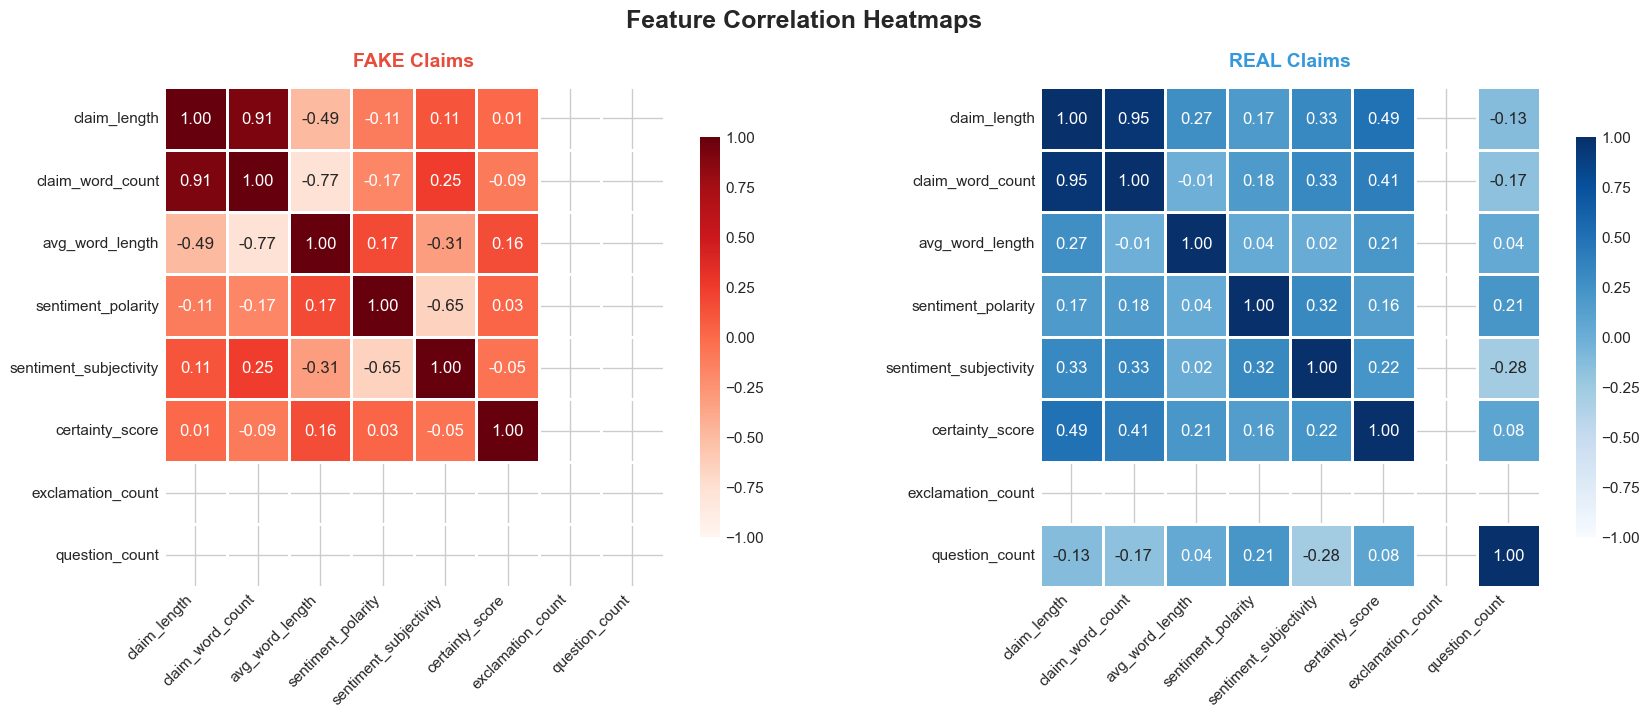

✓ Saved: viz6_correlation_heatmap.png


In [184]:
# =============================================
# VIZ 6: FEATURE CORRELATION HEATMAP
# =============================================

# Select numerical features
numeric_features = ['claim_length', 'claim_word_count', 'avg_word_length',
                   'sentiment_polarity', 'sentiment_subjectivity',
                   'certainty_score', 'exclamation_count', 'question_count']

# Compute correlation separately for fake and real
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Feature Correlation Heatmaps', fontsize=18, fontweight='bold', y=1.00)

# Fake claims
fake_corr = df_claims[df_claims['label']=='Fake'][numeric_features].corr()
sns.heatmap(fake_corr, annot=True, fmt='.2f', cmap='Reds', center=0,
            square=True, linewidths=1, cbar_kws={'shrink': 0.8},
            ax=axes[0], vmin=-1, vmax=1)
axes[0].set_title('FAKE Claims', fontsize=14, fontweight='bold', 
                  color='#E74C3C', pad=15)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0)

# Real claims
real_corr = df_claims[df_claims['label']=='Real'][numeric_features].corr()
sns.heatmap(real_corr, annot=True, fmt='.2f', cmap='Blues', center=0,
            square=True, linewidths=1, cbar_kws={'shrink': 0.8},
            ax=axes[1], vmin=-1, vmax=1)
axes[1].set_title('REAL Claims', fontsize=14, fontweight='bold',
                  color='#3498DB', pad=15)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('viz6_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: viz6_correlation_heatmap.png")